In [21]:
# %matplotlib notebook # comment this line when working in VSCode
%load_ext tensorboard

import aipy, uvtools
import numpy as np
import pylab as plt
import random
import math
import datetime
import os.path

from hera_sim import foregrounds, noise, sigchain, rfi

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import backend as K
from tensorflow.keras.utils import plot_model
from sklearn.model_selection import train_test_split, StratifiedKFold


The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [22]:
def plot_one_vis(vis, ylim):
    plt.figure()
    plt.subplot(211); uvtools.plot.waterfall(vis, mode='log', mx=MX, drng=DRNG); plt.colorbar(); plt.ylim(0,ylim)
    plt.subplot(212); uvtools.plot.waterfall(vis, mode='phs'); plt.colorbar(); plt.ylim(0,ylim)
    plt.show()

MX, DRNG = 2.5, 3

In [29]:
def load_data():
    # load and configure the dataset
    i = 1
    while(os.path.isfile(f'dataset{i+1}.npy')):
        i = i+1
    dataset = np.load(f'dataset{i}.npy')
    labels = np.load(f'labels{i}.npy')
    print(f'Dataset imported from dataset{i}.npy')
    X, y = dataset, labels
    print(f"Dataset shape: {X.shape}")
    
    # split into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)
    print(f"X_train.shape: {X_train.shape}, X_test.shape: {X_test.shape}")
    n_features = (X_train.shape[1], X_train.shape[2])
#     print(n_features)
    return X, y, X_train, y_train, X_test, y_test, n_features

def load_data_cv():
    # load and configure the dataset
    i = 1
    while(os.path.isfile(f'dataset{i+1}.npy')):
        i = i+1
    dataset = np.load(f'dataset{i}.npy')
    labels = np.load(f'labels{i}.npy')
    print(f'Dataset imported from dataset{i}.npy')
    X, y = dataset, labels
    print(f"Dataset shape: {X.shape}")
    n_features = (X.shape[1], X.shape[2])
    return X, y, n_features

def create_model(n_features):
    model = tf.keras.Sequential()
    model.add(layers.Flatten(input_shape=n_features))
    model.add(layers.Dense(25, activation='relu', kernel_initializer='he_normal'))
    model.add(layers.Dense(8, activation='relu', kernel_initializer='he_normal'))
    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy']) 
    return model

def train_and_evaluate_model(model, X_train, y_train, X_test, y_test):
    # logs for TensorBoard
    log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
    
    # fit the model
    history = model.fit(X_train, y_train, epochs=40, batch_size=32, verbose=1, validation_split=0.2, callbacks=[tensorboard_callback]) 

    # evaluate the model
    loss, acc = model.evaluate(X_test, y_test, verbose=1)
    print('Test Accuracy: %.3f' % acc)

    # make predictions
    predictions = model.predict_classes(X_test)
    predictions = predictions.flatten()
    # model.summary()
    return history, acc, predictions


- ReLu activation function: for x, it returns max(0, x)
- He weight initialization is a good option: https://towardsdatascience.com/weight-initialization-techniques-in-neural-networks-26c649eb3b78

In [26]:
def get_faulty_predictions(predictions, labels):
    my_list = []
    for i, val in enumerate(predictions):
        if predictions[i] != labels[i]:
            my_list.append(i)
    return my_list

def print_stats(accs, faulty_predictions, predictions):
    print(f"Mean accuracy: {np.mean(accs)}")
    print(f"Standard dev.: {np.std(accs)}")
    l = []
    for val in faulty_predictions:
        l.append(predictions[val])
    print(f"0's (RFI misclassified as clean): {np.bincount(l)[0]}")
    print(f"1's (clean misclassified as RFI): {np.bincount(l)[1]}")

def show_learning_curves(history):
    plt.title('Learning Curves')
    plt.xlabel('Epoch')
    plt.ylabel('Cross Entropy')
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='val')
    plt.yscale("log")
    plt.legend()
    plt.show()

# No Cross-validation

Dataset imported from dataset1.npy
Dataset shape: (1200, 20, 2048)
X_train.shape: (960, 20, 2048), X_test.shape: (240, 20, 2048)
Train on 768 samples, validate on 192 samples
Epoch 1/40
768/768 [==============================] - 4s 5ms/sample - loss: 189.1310 - accuracy: 0.8346 - val_loss: 61.2111 - val_accuracy: 0.8750
Epoch 2/40
768/768 [==============================] - 2s 2ms/sample - loss: 31.9892 - accuracy: 0.9701 - val_loss: 5.0650 - val_accuracy: 0.9740
Epoch 3/40
768/768 [==============================] - 2s 2ms/sample - loss: 0.0775 - accuracy: 0.9987 - val_loss: 3.0440 - val_accuracy: 0.9740
Epoch 4/40
768/768 [==============================] - 2s 2ms/sample - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 2.9392 - val_accuracy: 0.9792
Epoch 5/40
768/768 [==============================] - 1s 2ms/sample - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 2.9440 - val_accuracy: 0.9792
Epoch 6/40
768/768 [==============================] - 2s 2ms/sample - loss: 0.0000e+00 - accu

Test Accuracy: 0.988


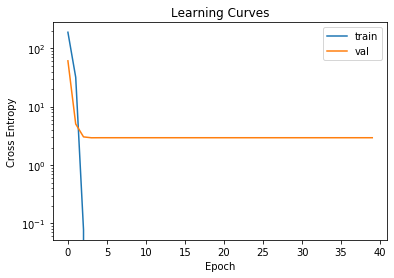

Mean accuracy: 0.987500011920929
Standard dev.: 0.0
0's (RFI misclassified as clean): 0
1's (clean misclassified as RFI): 3
Train on 768 samples, validate on 192 samples
Epoch 1/40
768/768 [==============================] - 4s 5ms/sample - loss: 211.7775 - accuracy: 0.7695 - val_loss: 267.8530 - val_accuracy: 0.8750
Epoch 2/40
768/768 [==============================] - 1s 2ms/sample - loss: 74.4599 - accuracy: 0.9388 - val_loss: 439.3794 - val_accuracy: 0.9844
Epoch 3/40
768/768 [==============================] - 1s 2ms/sample - loss: 2.7763 - accuracy: 0.9870 - val_loss: 431.7407 - val_accuracy: 0.9792
Epoch 4/40
768/768 [==============================] - 1s 1ms/sample - loss: 2.8370 - accuracy: 0.9974 - val_loss: 419.6012 - val_accuracy: 0.9688
Epoch 5/40
768/768 [==============================] - 1s 1ms/sample - loss: 0.9085 - accuracy: 0.9987 - val_loss: 414.7028 - val_accuracy: 0.9688
Epoch 6/40
768/768 [==============================] - 1s 1ms/sample - loss: 0.0166 - accuracy: 0.

Test Accuracy: 0.992


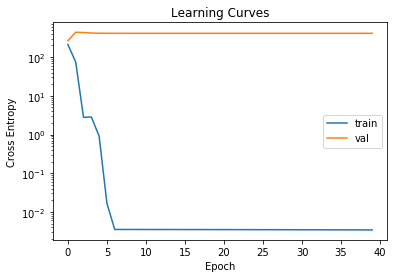

Mean accuracy: 0.9895833730697632
Standard dev.: 0.002083331346511841
0's (RFI misclassified as clean): 3
1's (clean misclassified as RFI): 2
Train on 768 samples, validate on 192 samples
Epoch 1/40
768/768 [==============================] - 3s 4ms/sample - loss: 94.6737 - accuracy: 0.8841 - val_loss: 186.3344 - val_accuracy: 0.9688
Epoch 2/40
768/768 [==============================] - 1s 2ms/sample - loss: 41.2563 - accuracy: 0.9635 - val_loss: 356.7867 - val_accuracy: 0.9740
Epoch 3/40
768/768 [==============================] - 1s 1ms/sample - loss: 30.9723 - accuracy: 0.9935 - val_loss: 329.2304 - val_accuracy: 0.9792
Epoch 4/40
768/768 [==============================] - 1s 1ms/sample - loss: 113.5460 - accuracy: 0.9922 - val_loss: 333.7015 - val_accuracy: 0.9896
Epoch 5/40
768/768 [==============================] - 1s 1ms/sample - loss: 33.6775 - accuracy: 0.9935 - val_loss: 357.2818 - val_accuracy: 0.9792
Epoch 6/40
768/768 [==============================] - 1s 1ms/sample - loss: 

Test Accuracy: 0.983


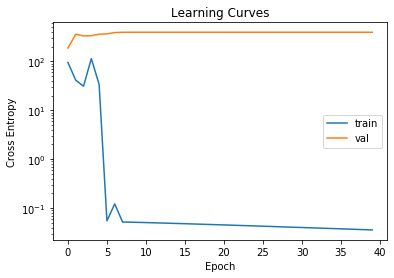

Mean accuracy: 0.987500011920929
Standard dev.: 0.0034020659513771534
0's (RFI misclassified as clean): 6
1's (clean misclassified as RFI): 3
Train on 768 samples, validate on 192 samples
Epoch 1/40
768/768 [==============================] - 3s 3ms/sample - loss: 342.5995 - accuracy: 0.6641 - val_loss: 446.0661 - val_accuracy: 0.6771
Epoch 2/40
768/768 [==============================] - 2s 3ms/sample - loss: 253.7135 - accuracy: 0.8438 - val_loss: 133.5231 - val_accuracy: 0.7812
Epoch 3/40
768/768 [==============================] - 1s 2ms/sample - loss: 495.2723 - accuracy: 0.9245 - val_loss: 113.3699 - val_accuracy: 0.8333
Epoch 4/40
768/768 [==============================] - 2s 3ms/sample - loss: 27.7008 - accuracy: 0.9622 - val_loss: 151.8096 - val_accuracy: 0.8646
Epoch 5/40
768/768 [==============================] - 1s 2ms/sample - loss: 2.6160 - accuracy: 0.9870 - val_loss: 184.1991 - val_accuracy: 0.8542
Epoch 6/40
768/768 [==============================] - 1s 2ms/sample - loss:

Test Accuracy: 0.925


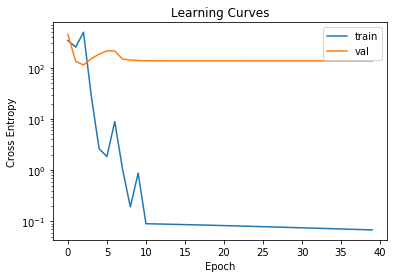

Mean accuracy: 0.971875011920929
Standard dev.: 0.027223195880651474
0's (RFI misclassified as clean): 8
1's (clean misclassified as RFI): 19


In [28]:
X, y, X_train, y_train, X_test, y_test, n_features = load_data()
faulty_predictions = []
accs = []

for i in range(4):

    model = None
    model = create_model(n_features)
    get_layer_output = K.function(inputs = model.layers[0].input, outputs = model.layers[1].output)

    layer_output = get_layer_output(X)

    history, acc, predictions = train_and_evaluate_model(model, X_train, y_train, X_test, y_test)
    accs.append(acc)
    faulty_predictions.extend(get_faulty_predictions(predictions, y_test))

    show_learning_curves(history)

    print_stats(accs, faulty_predictions, predictions)

# print(layer_output.shape)

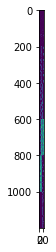

In [158]:
plt.imshow(layer_output)

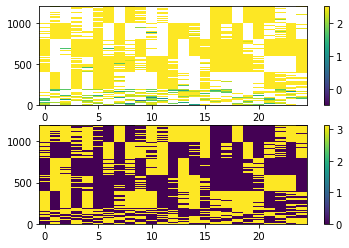

In [161]:
plot_one_vis(layer_output, 1200)

In [ ]:
%tensorboard --logdir logs/fit # show Tensorboard

## Visualize faulty predictions

Predicted: 1


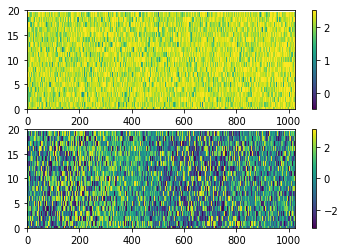

396


In [33]:
for i, val in enumerate(X):
    if i in faulty_predictions:
        print(f'Predicted: {predictions[i]}')
        plot_one_vis(val, 20)
print(len(predictions))

# Stratified K-fold Cross-validation

In [31]:
'''
n_splits = 3
X, y, n_features = load_data_cv()
skf = StratifiedKFold(n_splits, shuffle=True)

accs = []
faulty_predictions=[]

for i in range(4):
    print(f"Run {i}")
    for i, (train_index, test_index) in enumerate(skf.split(X, y)):
        # print(len(X[test_index]), len(y[train_index]))
        print("Running Fold", i+1, "/", n_splits)
        model = None # clear the NN
        model = create_model(n_features)
        history, acc, predictions = train_and_evaluate_model(model, X[train_index], y[train_index], X[test_index], y[test_index])
        accs.append(acc)
        faulty_predictions.extend(get_faulty_predictions(predictions, y[test_index]))
        
    show_learning_curves(history)
    print_stats(accs, faulty_predictions, predictions)
'''

'\nn_splits = 3\nX, y, n_features = load_data_cv()\nskf = StratifiedKFold(n_splits, shuffle=True)\n\naccs = []\nfaulty_predictions=[]\n\nfor i in range(4):\n    print(f"Run {i}")\n    for i, (train_index, test_index) in enumerate(skf.split(X, y)):\n        # print(len(X[test_index]), len(y[train_index]))\n        print("Running Fold", i+1, "/", n_splits)\n        model = None # clear the NN\n        model = create_model(n_features)\n        history, acc, predictions = train_and_evaluate_model(model, X[train_index], y[train_index], X[test_index], y[test_index])\n        accs.append(acc)\n        faulty_predictions.extend(get_faulty_predictions(predictions, y[test_index]))\n        \n    show_learning_curves(history)\n    print_stats(accs, faulty_predictions, predictions)\n'